<a href="https://colab.research.google.com/github/MohsenLotfii/School_electricity/blob/main/3_Schools_electricity_(29_Oct_2024).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


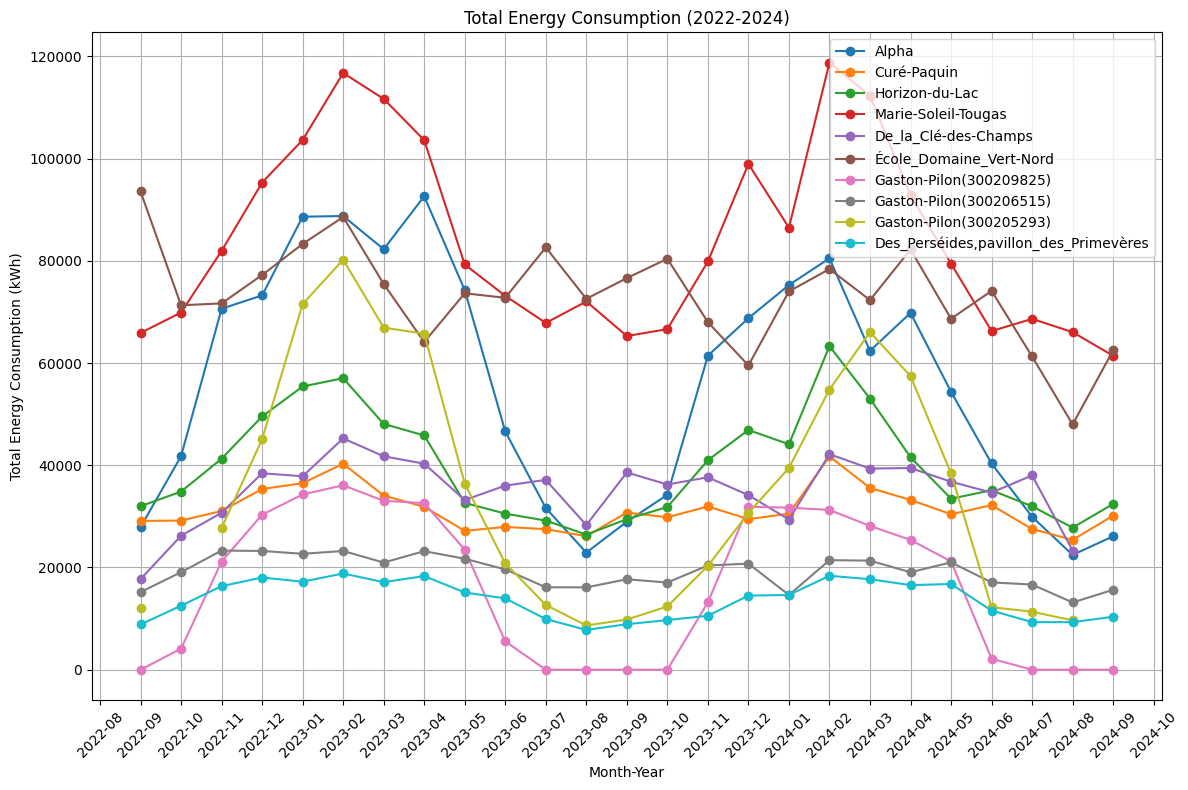

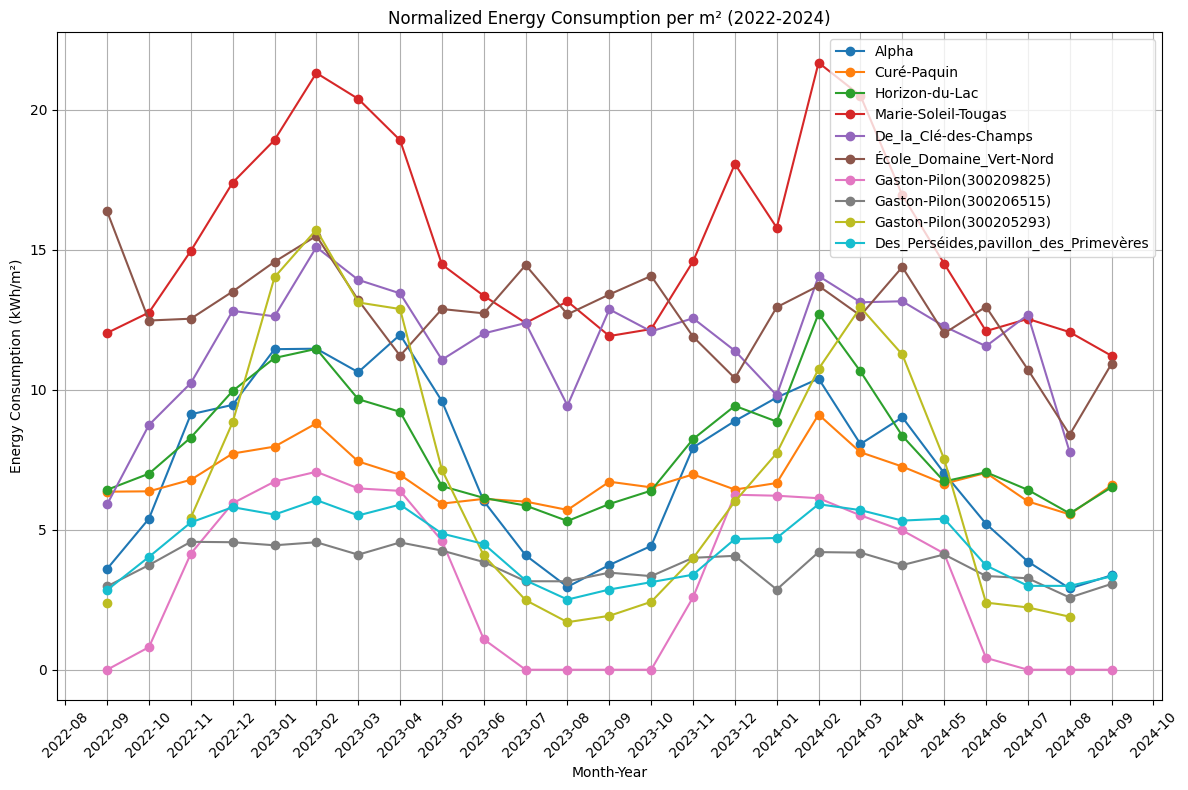

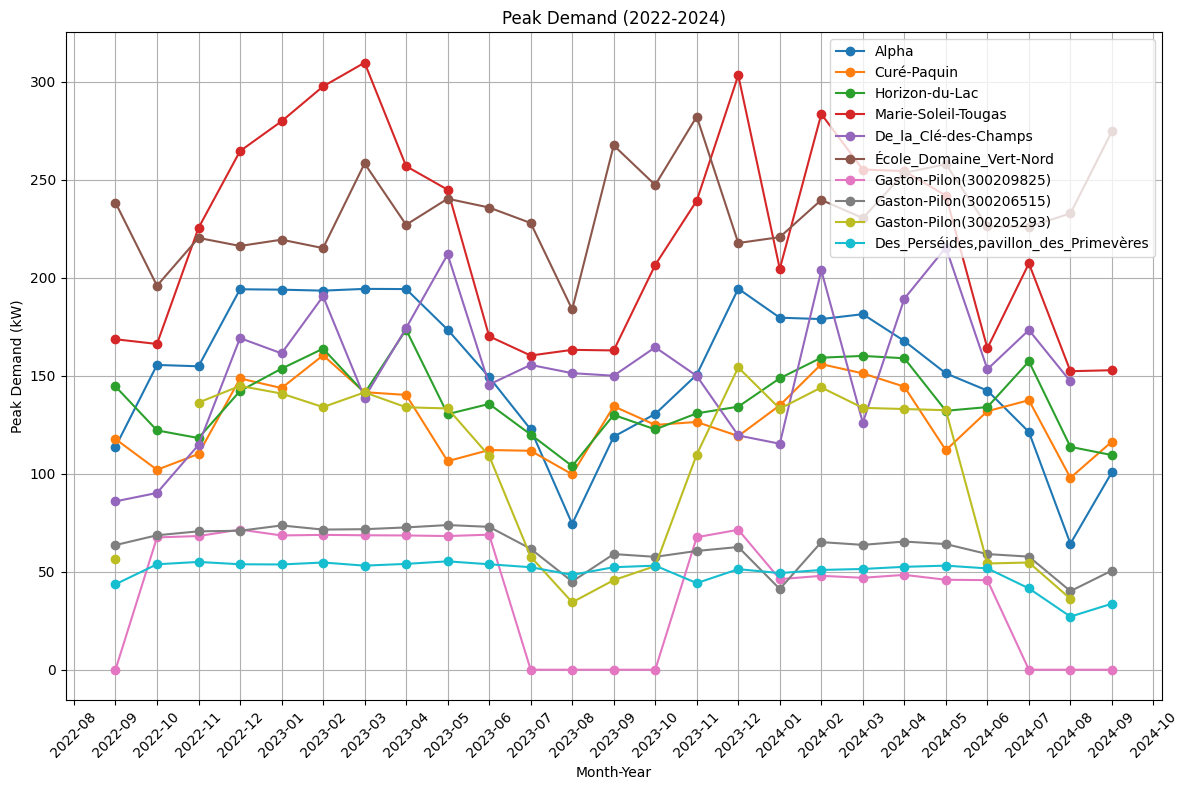

<Figure size 1200x800 with 0 Axes>

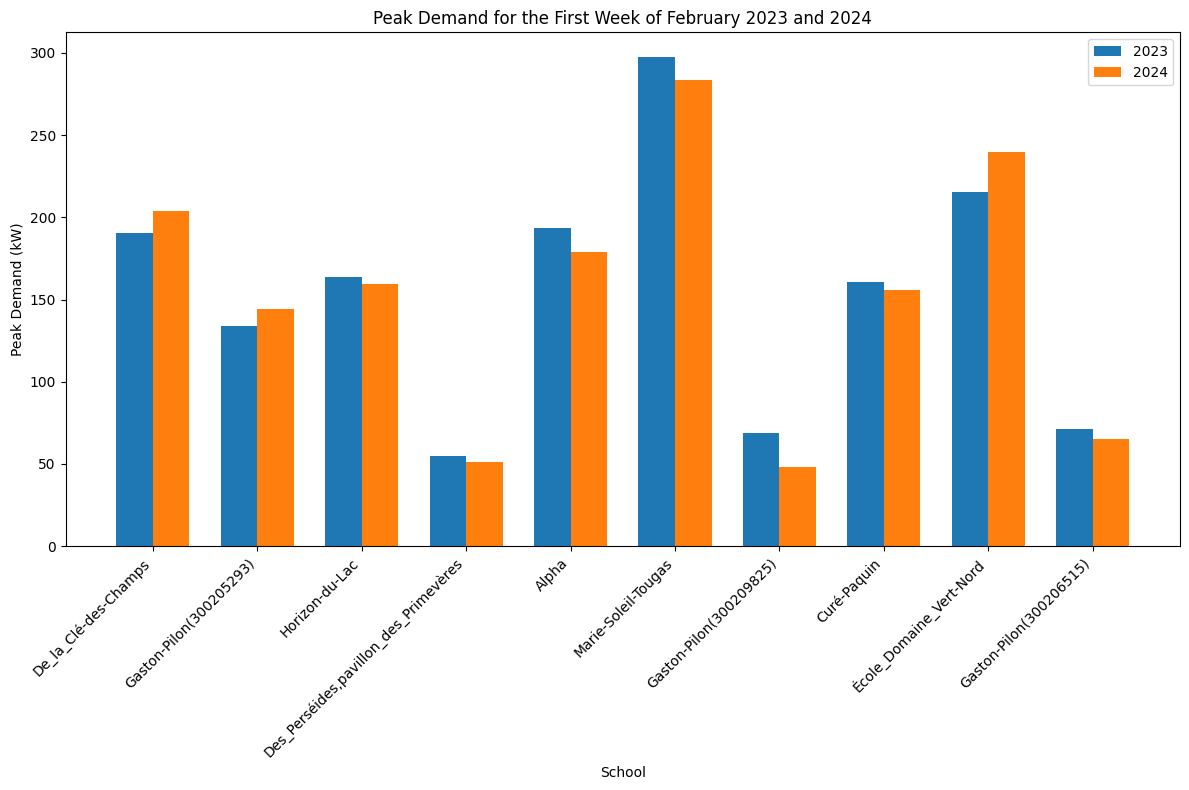

,School,Month-Year,Total Energy Consumption (kWh),Peak Demand (kW),Energy Cost (CAD),Demand Cost (CAD),Total Electricity Bill (CAD)
0,Alpha,2023-05,74257.35,173.5,4344.80,2942.91,7287.70
1,Alpha,2023-04,92615.17,194.2,5418.91,3294.02,8712.93
2,Alpha,2023-03,82264.15,194.3,4813.28,3295.72,8108.99
3,Alpha,2023-02,88754.62,193.4,5193.03,3280.45,8473.48
4,Alpha,2023-01,88620.43,193.9,5185.18,3288.93,8474.11
...,...,...,...,...,...,...,...
246,"Des_Perséides,pavillon_des_Primevères",2024-05,16762.83,53.1,980.79,900.68,1881.48
247,"Des_Perséides,pavillon_des_Primevères",2024-04,16551.00,52.5,968.40,890.50,1858.90
248,"Des_Perséides,pavillon_des_Primevères",2024-03,17711.65,51.4,1036.31,871.85,1908.16
249,"Des_Perséides,pavillon_des_Primevères",2024-02,18371.23,50.9,1074.90,863.37,1938.27


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Floor areas for each school (in square meters)
floorAreas = {
    "Alpha": 7742,
    "Curé-Paquin": 4579,  # I used google map for the calculation of the area
    "Des_Perséides,pavillon_des_Primevères": 3108,
    "Gaston-Pilon(300209825)": 5103,
    "Gaston-Pilon(300206515)": 5103,
    "Gaston-Pilon(300205293)": 5103,
    "De_la_Clé-des-Champs": 2999,
    "Horizon-du-Lac": 4977,
    "Marie-Soleil-Tougas": 5478,
    "École_Domaine_Vert-Nord": 5717
}

# List of paths for different schools
schoolPaths = [
    "/content/drive/MyDrive/🍁 /UdS/Thesis/Projects/Alpha",
    "/content/drive/MyDrive/🍁 /UdS/Thesis/Projects/Curé-Paquin",
    "/content/drive/MyDrive/🍁 /UdS/Thesis/Projects/Horizon-du-Lac",
    "/content/drive/MyDrive/🍁 /UdS/Thesis/Projects/Marie-Soleil-Tougas",
    "/content/drive/MyDrive/🍁 /UdS/Thesis/Projects/De_la_Clé-des-Champs",
    "/content/drive/MyDrive/🍁 /UdS/Thesis/Projects/École_Domaine_Vert-Nord",
    "/content/drive/MyDrive/🍁 /UdS/Thesis/Projects/Gaston-Pilon(300209825)",
    "/content/drive/MyDrive/🍁 /UdS/Thesis/Projects/Gaston-Pilon(300206515)",
    "/content/drive/MyDrive/🍁 /UdS/Thesis/Projects/Gaston-Pilon(300205293)",
    "/content/drive/MyDrive/🍁 /UdS/Thesis/Projects/Des_Perséides,pavillon_des_Primevères",
]

# Hydro-Québec Rate M parameters
demandRate = 16.962  # CAD per kW (monthly)
energyRateFirst210kWh = 0.05851  # CAD per kWh for the first 210,000 kWh
energyRateAbove210kWh = 0.04339  # CAD per kWh for consumption above 210,000 kWh
thresholdKWh = 210000  # kWh

# List to store bill information for each school and month
billsSummary = []

# Initialize dictionaries to hold data for each school
schoolMonths = {}
schoolTotalEnergyKWh = {}
schoolNormalizedEnergyKWh = {}
schoolPeakDemandKw = {}

# Function to process CSV files and update bill information
def process_school_files(schoolPath, schoolName, floorArea):
    csvFiles = [file for file in os.listdir(schoolPath) if file.endswith('.csv')]
    dfAllSchool = pd.DataFrame()  # Initialize an empty DataFrame to store all data for the current school

    # Initialize lists for plotting
    months = []
    totalEnergyKWhList = []
    normalizedEnergyKWhList = []
    peakDemandKwList = []

    # Process each CSV file (each month)
    for filename in csvFiles:
        fullPath = os.path.join(schoolPath, filename)
        # Commented out the print statement to avoid showing file processing info
        # print(f"Processing file: {fullPath}")

        try:
            df = pd.read_csv(fullPath, delimiter=';', decimal=',')
            df.iloc[:, 1] = pd.to_datetime(df.iloc[:, 1], errors='coerce')
            df = df.dropna(subset=[df.columns[1]])
            df.iloc[:, 2] = pd.to_numeric(df.iloc[:, 2], errors='coerce')
            df = df.dropna(subset=[df.columns[2]])
            dfAllSchool = pd.concat([dfAllSchool, df], ignore_index=True)

            # Calculate total energy consumption in kWh (15-minute intervals)
            df['EnergyKWh'] = df.iloc[:, 2] / 4
            totalEnergyKWh = df['EnergyKWh'].sum()
            normalizedEnergyKWh = totalEnergyKWh / floorArea
            peakDemandKw = df.iloc[:, 2].max()

            # Calculate the energy cost
            if totalEnergyKWh <= thresholdKWh:
                energyCost = totalEnergyKWh * energyRateFirst210kWh
            else:
                energyCost = (thresholdKWh * energyRateFirst210kWh +
                              (totalEnergyKWh - thresholdKWh) * energyRateAbove210kWh)

            billingDemandKw = peakDemandKw
            demandCost = billingDemandKw * demandRate

            # Calculate the total electricity bill for this month
            totalBill = energyCost + demandCost

            # Extract the first date in the file for table (month and year)
            firstDate = df.iloc[0, 1]
            monthYearLabel = firstDate.strftime('%Y-%m')

            # Store the bill information in the list for later table creation
            billsSummary.append({
                "School": schoolName,
                "Month-Year": monthYearLabel,
                "Total Energy Consumption (kWh)": round(totalEnergyKWh, 2),
                "Peak Demand (kW)": round(peakDemandKw, 2),
                "Energy Cost (CAD)": round(energyCost, 2),
                "Demand Cost (CAD)": round(demandCost, 2),
                "Total Electricity Bill (CAD)": round(totalBill, 2)
            })

            # Add data for plotting
            months.append(monthYearLabel)
            totalEnergyKWhList.append(totalEnergyKWh)
            normalizedEnergyKWhList.append(normalizedEnergyKWh)
            peakDemandKwList.append(peakDemandKw)

        except Exception as e:
            # Record "incomplete data" in the bills summary if an error occurs
            billsSummary.append({
                "School": schoolName,
                "Month-Year": filename.replace('.csv', ''),
                "Total Energy Consumption (kWh)": "incomplete data",
                "Peak Demand (kW)": "incomplete data",
                "Energy Cost (CAD)": "incomplete data",
                "Demand Cost (CAD)": "incomplete data",
                "Total Electricity Bill (CAD)": "incomplete data"
            })

    # Store the data for this school
    schoolMonths[schoolName] = months
    schoolTotalEnergyKWh[schoolName] = totalEnergyKWhList
    schoolNormalizedEnergyKWh[schoolName] = normalizedEnergyKWhList
    schoolPeakDemandKw[schoolName] = peakDemandKwList

# Process each school
for schoolPath in schoolPaths:
    schoolName = os.path.basename(schoolPath)
    floorArea = floorAreas.get(schoolName, 0)  # Get the floor area for the current school, default to 0 if not found
    process_school_files(schoolPath, schoolName, floorArea)

# Function to plot data for all years together
def plot_all_years(data_dict, ylabel, title, filename_prefix):
    plt.figure(figsize=(12, 8))
    for schoolName, dataList in data_dict.items():
        all_months = [f"{year}-{str(month).zfill(2)}" for year in range(2022, 2025) for month in range(1, 13)]
        data_dict_all = {month: np.nan for month in all_months}

        for month, data in zip(schoolMonths[schoolName], dataList):
            if month in data_dict_all:
                data_dict_all[month] = data

        plotted_data = [data_dict_all[month] for month in all_months]

        plt.plot(all_months, plotted_data, marker='o', linestyle='-', label=schoolName)
    plt.title(title)
    plt.xlabel('Month-Year')
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{filename_prefix}.png")
    plt.show()

# Plot total energy consumption for all years together
plot_all_years(schoolTotalEnergyKWh, 'Total Energy Consumption (kWh)', 'Total Energy Consumption (2022-2024)', 'TotalEnergyConsumption_AllYears')

# Plot normalized energy consumption for all years together
plot_all_years(schoolNormalizedEnergyKWh, 'Energy Consumption (kWh/m²)', 'Normalized Energy Consumption per m² (2022-2024)', 'NormalizedEnergyConsumption_AllYears')

# Plot peak demand for all years together
plot_all_years(schoolPeakDemandKw, 'Peak Demand (kW)', 'Peak Demand (2022-2024)', 'PeakDemand_AllYears')

# Function to plot peak demand for the first week of February in 2023 and 2024
def plot_peak_demand_for_first_week(school_peak_demand_dict, filename_prefix):
    plt.figure(figsize=(12, 8))

    # Initialize data storage
    data_2023 = {}
    data_2024 = {}

    for schoolName in school_peak_demand_dict:
        # Extract peak demand for the first week of February 2023 and 2024
        for month in schoolMonths[schoolName]:
            if month.startswith('2023-02') or month.startswith('2024-02'):
                week_of_year = pd.to_datetime(month + '-01').isocalendar().week
                if month.startswith('2023-02'):
                    if week_of_year == 5:  # First week of February 2023
                        data_2023[schoolName] = school_peak_demand_dict[schoolName][schoolMonths[schoolName].index(month)]
                elif month.startswith('2024-02'):
                    if week_of_year == 5:  # First week of February 2024
                        data_2024[schoolName] = school_peak_demand_dict[schoolName][schoolMonths[schoolName].index(month)]

    # Plotting
    school_names = list(set(data_2023.keys()).union(data_2024.keys()))
    peak_demand_2023 = [data_2023.get(school, np.nan) for school in school_names]
    peak_demand_2024 = [data_2024.get(school, np.nan) for school in school_names]

    x = np.arange(len(school_names))  # The label locations
    width = 0.35  # The width of the bars

    fig, ax = plt.subplots(figsize=(12, 8))
    bars1 = ax.bar(x - width/2, peak_demand_2023, width, label='2023')
    bars2 = ax.bar(x + width/2, peak_demand_2024, width, label='2024')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('School')
    ax.set_ylabel('Peak Demand (kW)')
    ax.set_title('Peak Demand for the First Week of February 2023 and 2024')
    ax.set_xticks(x)
    ax.set_xticklabels(school_names, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.savefig(f"{filename_prefix}.png")
    plt.show()

# Plot peak demand for the first week of February in 2023 and 2024
plot_peak_demand_for_first_week(schoolPeakDemandKw, 'PeakDemand_1stWeek_February_2023_2024')

# Convert the bills summary list into a DataFrame for easy table formatting
billsDf = pd.DataFrame(billsSummary)

# Display the summary DataFrame
billsDf
